In [1]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from transformers import (
    SegformerForSemanticSegmentation, 
    TrainingArguments, Trainer, 
    SegformerImageProcessor)
import evaluate
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast

c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Ïª§Ïä§ÌÖÄ Îç∞Ïù¥ÌÑ∞ ÏÖã

In [2]:
import json
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import numpy as np
import os
import glob


class CustomDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.class_map = {}
        self.next_class_index = 1
        self.label_list = os.listdir(self.ann_dir)
        self.img_paths = []
        self.ann_paths = []
        
        # ÎØ∏Î¶¨ Í≤ΩÎ°ú Í≥ÑÏÇ∞
        for label in self.label_list:
            with open(os.path.join(self.ann_dir, label), 'r', encoding='utf-8') as f:
                img_info = json.load(f)
            img_path = os.path.join(self.img_dir, img_info['name'])
            self.img_paths.append(img_path)
            self.ann_paths.append(os.path.join(self.ann_dir, label))

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        ann_path = self.ann_paths[idx]
        
        with open(ann_path, 'r', encoding='utf-8') as f:
            img_info = json.load(f)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.new('L', (image.width, image.height))
        draw = ImageDraw.Draw(mask)
        
        for obj in img_info['objects']:
            class_id = self.get_class_index(obj['label'])
            for pos in obj['position']:
                polygon= tuple(pos)
            
                draw.polygon(polygon, outline=1, fill=class_id)

        mask = np.array(mask)
        
        if self.transforms:
            image = self.transforms(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

    def get_class_index(self, label):
        if label not in self.class_map:
            self.class_map[label] = self.next_class_index
            self.next_class_index += 1
        return self.class_map[label]





In [3]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
# import albumentations as A
# from albumentations.pytorch import ToTensorV2 

### Data augmentationÏùÑ Í≥†Î†§Ìï† ÌïÑÏöîÍ∞Ä ÏûàÏùå

train_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# DataLoader ÏÑ§Ï†ï
train_dataset = CustomDataset("C:/Users/USER/Desktop/resized_train_image", "C:/Users/USER/Desktop/train_label_final/train_label", transforms=train_transforms)
val_dataset = CustomDataset("C:/Users/USER/Desktop/resize_valid_image", "C:/Users/USER/Desktop/valid_label_final/valid_label", transforms=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

### Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original coordinates: [[359.50390625, 1080.0, 914.78156374, 920.58624886, 935.37176757, 901.52935808, 959.68573167, 893.20565866, 987.8329784, 887.07240645, 1085.19835716, 838.44447825, 1107.21235169, 833.84453909, 1143.35473076, 833.84453909, 1136.67386675, 837.78734408, 1142.47855187, 839.53970186, 1157.81168239, 844.46820809, 1191.32552479, 858.04898083, 1219.91086097, 872.61545482, 1267.00547612, 895.06753879, 1380.14207484, 970.19987831, 1406.09887435, 977.7569212, 1452.97444478, 989.80438089, 1479.69790082, 1010.06601765, 1478.38363249, 1027.15150593, 1585.49650137, 1080.0]]
Converted coordinates: (359.50390625, 1080.0, 914.78156374, 920.58624886, 935.37176757, 901.52935808, 959.68573167, 893.20565866, 987.8329784, 887.07240645, 1085.19835716, 838.44447825, 1107.21235169, 833.84453909, 1143.35473076, 833.84453909, 1136.67386675, 837.78734408, 1142.47855187, 839.53970186, 1157.81168239, 844.46820809, 1191.32552479, 858.04898083, 1219.91086097, 872.61545482, 1267.00547612, 895.0675

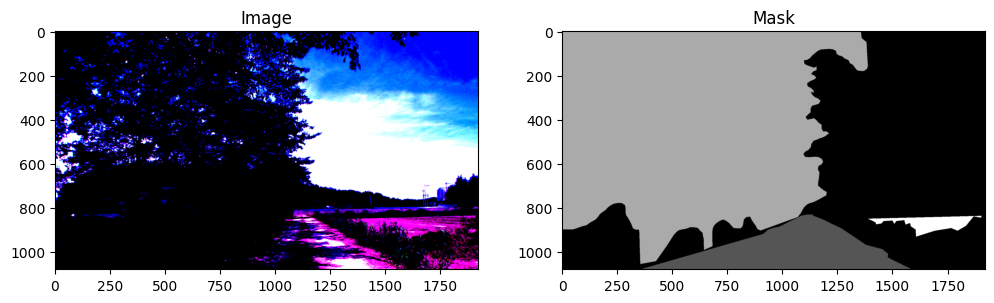

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original coordinates: [[405.65429688, 1080.0, 765.40523274, 980.8752662, 928.92820201, 913.94493459, 938.81563736, 900.25463949, 1089.40888348, 838.64831153, 1146.14755096, 834.99756617, 1139.98691816, 839.40888348, 1171.70276848, 849.98083359, 1243.88104655, 888.69394585, 1287.46181929, 908.46881655, 1328.22847581, 942.16215394, 1558.52966231, 1080.0]]
Converted coordinates: (405.65429688, 1080.0, 765.40523274, 980.8752662, 928.92820201, 913.94493459, 938.81563736, 900.25463949, 1089.40888348, 838.64831153, 1146.14755096, 834.99756617, 1139.98691816, 839.40888348, 1171.70276848, 849.98083359, 1243.88104655, 888.69394585, 1287.46181929, 908.46881655, 1328.22847581, 942.16215394, 1558.52966231, 1080.0)
Original coordinates: [[1916.8, 837.9, 1920.0, 853.2, 1870.91598372, 844.74055916, 1835.20517406, 887.25342782, 1797.79384964, 909.36011952, 1768.88509896, 897.45651629, 1694.06245013, 909.36011952, 1609.03671283, 936.56835545, 1607.33619808, 904.25857528, 1585.22950638, 889.80419994, 158

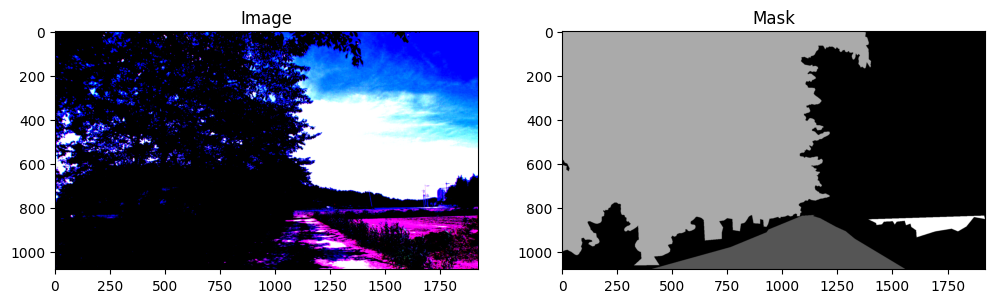

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original coordinates: [[711.08256173, 853.49736773, 712.4, 866.0, 729.9, 891.9, 717.78515625, 937.95507812, 678.37304688, 940.58984375, 646.24149681, 939.90161241, 641.35241862, 850.95193185, 622.42695467, 844.48573167, 622.11153027, 844.01259507, 607.12887131, 844.01259507, 597.19300274, 851.74049285, 588.04569516, 859.46839063, 583.15661698, 871.9276544, 589.14968056, 880.75953757, 597.19300274, 891.32625494, 598.61241253, 902.68153331, 589.14968056, 908.6745969, 568.96251901, 905.6780651, 568.17395802, 896.05762093, 567.85853362, 896.05762093, 559.34207484, 895.74219653, 551.29875266, 898.73872832, 551.61417706, 899.36957712, 550.51019166, 907.8860359, 545.14797688, 908.9900213, 534.42354731, 908.2014603, 534.10812291, 908.6745969, 523.06826894, 909.77858229, 521.64885914, 909.77858229, 516.44435656, 918.45275327, 516.44435656, 918.92588987, 510.60900517, 923.34183146, 503.66966839, 920.02987527, 492.31439002, 921.44928506, 491.84125342, 921.44928506, 488.52929723, 926.18065105, 494

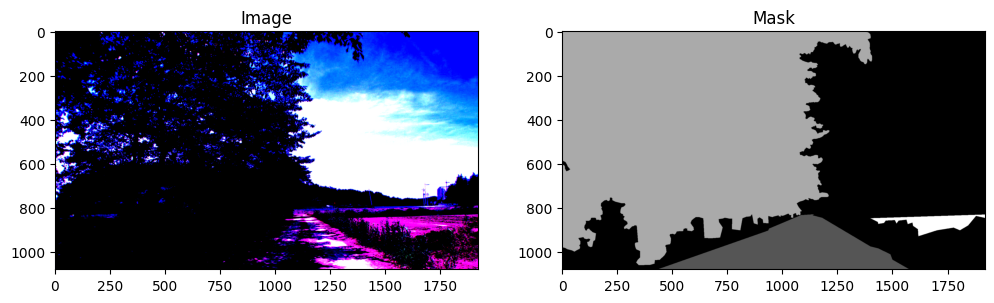

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original coordinates: [[1920.0, 824.29550781, 1920.0, 839.59550781, 1883.67086654, 831.13606698, 1847.96005687, 873.64893563, 1810.54873246, 895.75562733, 1767.2, 887.3, 1681.3, 907.7, 1621.79159564, 922.96386327, 1620.09108089, 890.65408309, 1597.98438919, 876.19970775, 1594.5833597, 860.89507503, 1574.17718275, 867.69713402, 1568.22538114, 848.14121444, 1532.51457147, 852.3925013, 1523.16174037, 865.1463619, 1514.65916664, 849.84172918, 1473.84681273, 852.3925013, 1465.344239, 863.44584715, 1439.83651781, 866.84687664, 1438.13600306, 858.34430291, 1402.42519339, 841.33915545]]
Converted coordinates: (1920.0, 824.29550781, 1920.0, 839.59550781, 1883.67086654, 831.13606698, 1847.96005687, 873.64893563, 1810.54873246, 895.75562733, 1767.2, 887.3, 1681.3, 907.7, 1621.79159564, 922.96386327, 1620.09108089, 890.65408309, 1597.98438919, 876.19970775, 1594.5833597, 860.89507503, 1574.17718275, 867.69713402, 1568.22538114, 848.14121444, 1532.51457147, 852.3925013, 1523.16174037, 865.1463619, 

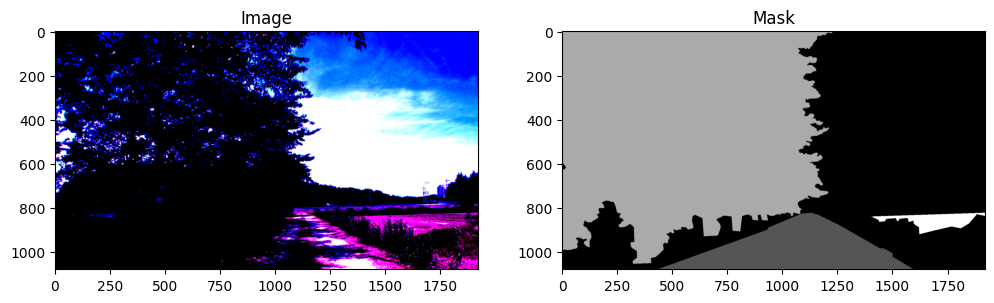

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original coordinates: [[1613.2265625, 1080.0, 1341.95679951, 929.66342156, 1249.42054558, 880.86005476, 1172.66615962, 837.50745361, 1139.20099381, 830.40878207, 1143.57428253, 823.8171585, 1082.41162154, 831.29611601, 962.24125342, 888.08548829, 938.9, 896.1, 481.36963797, 1080.0]]
Converted coordinates: (1613.2265625, 1080.0, 1341.95679951, 929.66342156, 1249.42054558, 880.86005476, 1172.66615962, 837.50745361, 1139.20099381, 830.40878207, 1143.57428253, 823.8171585, 1082.41162154, 831.29611601, 962.24125342, 888.08548829, 938.9, 896.1, 481.36963797, 1080.0)
Original coordinates: [[712.9504434, 902.88451665, 711.87797546, 955.97167998, 675.4140625, 962.94335938, 632.46993206, 963.31873035, 629.74454923, 859.31051617, 606.48372376, 848.85265186, 603.82172193, 848.85265186, 588.42013995, 851.51465369, 580.94118244, 853.73298854, 572.13122401, 859.43727817, 558.06064294, 877.05719501, 535.87729439, 892.33201501, 531.56738667, 909.76178887, 531.2504817, 909.76178887, 526.05324004, 907.92

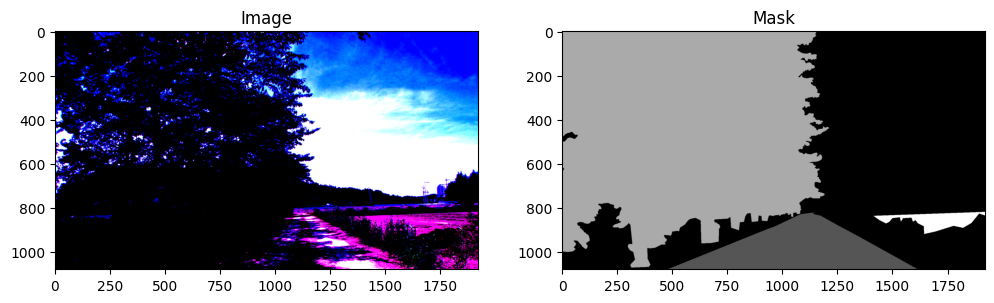

In [ ]:
train_dataset = CustomDataset("C:/Users/USER/Desktop/train_image_final/train_image", "C:/Users/USER/Desktop/train_label_final/train_label", transforms=train_transforms)

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
def check_sample_data(dataset, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i]
        
        # Ïù¥ÎØ∏ÏßÄÎ•º Ï∂úÎ†•
        image_np = image.numpy().transpose(1, 2, 0)
        mask_np = mask.numpy()
        
        print(f"Sample {i+1}")
        print("Image shape:", image_np.shape)
        print("Mask shape:", mask_np.shape)
        print("Unique mask values:", np.unique(mask_np))
        
        # Ïù¥ÎØ∏ÏßÄÏôÄ ÎßàÏä§ÌÅ¨ ÏãúÍ∞ÅÌôî
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title("Image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Mask")
        
        plt.show()

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ Ïã§Ìñâ
check_sample_data(train_dataset)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 71418
Number of validation examples: 24468


### Î™®Îç∏ ÏÑ§Ï†ï

In [4]:
# ÌÅ¥ÎûòÏä§ ID Î∞è Î†àÏù¥Î∏î Îß§Ìïë Ï†ïÏùò
id2label = {
    0: 'common_road',
    1: 'common_tree',
    2: 'field_corps',
    3: 'field_furrow',
    4: 'field_levee',
    5: 'orchard_road',
    6: 'orchard_tree',
    7: 'paddy_after_driving',
    8: 'paddy_before_driving',
    9: 'paddy_edge',
    10: 'paddy_rice',
    11: 'paddy_water'
}

# Î∞òÎåÄ Îß§Ìïë ÏÉùÏÑ±
label2id = {v: k for k, v in id2label.items()}


In [5]:
# Pre-trained models
# MODEL_CHECKPOINT = 'nvidia/mit-b0'
# MODEL_CHECKPOINT = 'nvidia/mit-b1'
# MODEL_CHECKPOINT = 'nvidia/mit-b2'
MODEL_CHECKPOINT = 'nvidia/mit-b3'
# MODEL_CHECKPOINT = 'nvidia/mit-b4'
# MODEL_CHECKPOINT = 'nvidia/mit-b5'
# MODEL_CHECKPOINT = 'nvidia/segformer-b4-finetuned-cityscapes-1024-1024'

VAL_SIZE = 0.1
BATCH_SIZE = 2
EPOCHS = 1
LR = 0.00006

IMG_SIZE = 512

In [6]:
from transformers import SegformerForSemanticSegmentation


# Î™®Îç∏ Ï¥àÍ∏∞Ìôî
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(id2label),  # ÌÅ¥ÎûòÏä§ Ïàò ÏßÄÏ†ï
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú Î™®Îç∏Í≥º ÌÅ¨Í∏∞ Î∂àÏùºÏπò Î¨¥Ïãú
)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### ÌõàÎ†®

In [7]:
from datasets import load_metric
metric = load_metric("mean_iou")

C:\Users\USER\AppData\Local\Temp\ipykernel_3284\3826925839.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library ü§ó Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("mean_iou")
c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for mean_iou contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/mean_iou/mean_iou.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [8]:
import numpy as np
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from datasets import load_metric

scaler = GradScaler()

def validate_amp(model, val_loader, device, scaler):
    model.eval()
    total_loss = 0
    metric = load_metric("accuracy")  # ÏòàÏãú Î©îÌä∏Î¶≠

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch[0].to(device).float()
            labels = batch[1].to(device).long()

            # autocast ÏÇ¨Ïö©
            with autocast():
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                upsampled_logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                loss = F.cross_entropy(upsampled_logits, labels, ignore_index=255)

            total_loss += loss.item()

            # ÏÑ±Îä• ÌèâÍ∞Ä
            predicted = upsampled_logits.argmax(dim=1)
            metric.add_batch(predictions=predicted.cpu().numpy(), references=labels.cpu().numpy())

    # ÌèâÍ∑† ÏÜêÏã§ Í≥ÑÏÇ∞
    avg_loss = total_loss / len(val_loader)
    # Î©îÌä∏Î¶≠ Í≥ÑÏÇ∞
    metrics_result = metric.compute()

    return avg_loss, metrics_result

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ÌõàÎ†® Î∞è Í≤ÄÏ¶ù Î£®ÌîÑ
model.train()
for epoch in range(10):
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/10", unit="batch") as pbar:
        train_loss = 0
        for idx, batch in enumerate(train_loader):
            pixel_values = batch[0].to(device).float()
            labels = batch[1].to(device).long()

            optimizer.zero_grad()

            # autocast Ïª®ÌÖçÏä§Ìä∏ Îß§ÎãàÏ†Ä ÎÇ¥ÏóêÏÑú Î™®Îç∏Ïùò forward pass Ïã§Ìñâ
            with autocast():
                outputs = model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

            # Ïä§ÏºÄÏùºÎü¨Î•º ÏÇ¨Ïö©ÌïòÏó¨ lossÏùò Ïä§ÏºÄÏùº Ï°∞Ï†ï Î∞è backward Ïã§Ìñâ
            scaler.scale(loss).backward()
            scaler.step(optimizer)  # Ïä§ÏºÄÏùºÎêú Í∑∏ÎùºÎîîÏñ∏Ìä∏Î•º ÏÇ¨Ïö©ÌïòÏó¨ optimizerÎ•º ÏóÖÎç∞Ïù¥Ìä∏
            scaler.update()  # Ïä§ÏºÄÏùºÎü¨Î•º ÏóÖÎç∞Ïù¥Ìä∏

            train_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        # ÏóêÌè¨ÌÅ¨ Ï¢ÖÎ£å ÌõÑ Í≤ÄÏ¶ù Ïã§Ìñâ
        val_loss, val_metrics = validate_amp(model, val_loader, device, scaler)
        print(f"Validation Loss: {val_loss}")
        print(f"Validation Metrics: {val_metrics}")


Epoch 1/10:   3%|‚ñé         | 72/2232 [20:18<10:34:32, 17.63s/batch, loss=0.5159]

### ÏµúÏ¢Ö ÌõàÎ†®ÏΩîÎìú

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_metric
import wandb
import evaluate  # evaluate ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§

import os

# Ï†ÄÏû•Ìï† Ìè¥Îçî ÏßÄÏ†ï Î∞è ÏÉùÏÑ±
model_save_path = "saved_models"
model_filename = "best_model.pth"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
full_model_path = os.path.join(model_save_path, model_filename)

# wandb Ï¥àÍ∏∞Ìôî
wandb.init()

# ÏÑ§Ï†ï Î≥ÄÏàò
gradient_accumulation_steps = 4
best_mean_iou = 0.0

iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # evaluate ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÏÇ¨Ïö©ÌïòÏó¨ Î©îÌä∏Î¶≠ Î°úÎìú

# validation
def validate_amp(model, val_loader, device, scaler, num_labels=21, ignore_index=255):
    model.eval()  # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú Ï†ÑÌôò
    total_loss = 0
    iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # Í∞Å Í≤ÄÏ¶ù Î£®ÌîÑÎßàÎã§ Î©îÌä∏Î¶≠ÏùÑ ÏÉàÎ°ú Ï¥àÍ∏∞Ìôî
    
    with torch.no_grad():  
        pbar = tqdm(total=len(val_loader), desc="Validating", unit="batch")  # tqdmÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Í≤ÄÏ¶ù ÏßÑÌñâ ÏÉÅÌô© ÌëúÏãú
        for batch in val_loader:
            pixel_values = batch[0].to(device).float()  # ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Î•º Ïû•ÏπòÎ°ú Ïù¥Îèô
            labels = batch[1].to(device).long()  # ÎùºÎ≤® Îç∞Ïù¥ÌÑ∞Î•º Ïû•ÏπòÎ°ú Ïù¥Îèô
            
            with autocast():  # ÏûêÎèô ÌòºÌï© Ï†ïÎ∞ÄÎèÑ(AMP)Î•º ÏÇ¨Ïö©ÌïòÏó¨ Ïó∞ÏÇ∞
                outputs = model(pixel_values=pixel_values)  
                logits = outputs.logits  # Î°úÏßì Í∞í
                upsampled_logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)  # Î°úÏßìÏùÑ ÎùºÎ≤® ÌÅ¨Í∏∞Î°ú Î≥¥Í∞Ñ
                loss = F.cross_entropy(upsampled_logits, labels, ignore_index=255)  # ÍµêÏ∞® ÏóîÌä∏Î°úÌîº ÏÜêÏã§ Í≥ÑÏÇ∞
                
            total_loss += loss.item()  # Ï¥ù ÏÜêÏã§ Í≥ÑÏÇ∞
            predicted = upsampled_logits.argmax(dim=1)  # ÏòàÏ∏°Í∞í Í≥ÑÏÇ∞
            iou_metric.add_batch(predictions=predicted, references=labels)  # Î©îÌä∏Î¶≠Ïóê Î∞∞Ïπò Ï∂îÍ∞Ä
            pbar.update(1) 

        pbar.close()  

    avg_loss = total_loss / len(val_loader)  # ÌèâÍ∑† ÏÜêÏã§ Í≥ÑÏÇ∞
    mean_iou = iou_metric.compute(num_labels=num_labels, ignore_index=ignore_index)  # Mean IoU Í≥ÑÏÇ∞
    return avg_loss, mean_iou  # ÌèâÍ∑† ÏÜêÏã§Í≥º Mean IoU Î∞òÌôò

# Î™®Îç∏, optimizer, device ÏÑ§Ï†ï
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)  # AdamW ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA ÎòêÎäî CPU Ïû•Ïπò ÏÑ§Ï†ï
model.to(device)  
scaler = GradScaler()  # GradScaler ÏÑ§Ï†ï (AMPÎ•º ÏúÑÌïú Ïä§ÏºÄÏùºÎü¨)

# ÌõàÎ†® Î∞è Í≤ÄÏ¶ù Î£®ÌîÑ
for epoch in range(10):
    model.train()  
    train_loss = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/10", unit="batch")  # tqdmÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌõàÎ†® ÏßÑÌñâ ÏÉÅÌô© ÌëúÏãú
    for idx, batch in enumerate(train_loader):
        pixel_values = batch[0].to(device).float()  # ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Î•º Ïû•ÏπòÎ°ú Ïù¥Îèô
        labels = batch[1].to(device).long()  # ÎùºÎ≤® Îç∞Ïù¥ÌÑ∞Î•º Ïû•ÏπòÎ°ú Ïù¥Îèô

        optimizer.zero_grad(set_to_none=True)  # ÏòµÌã∞ÎßàÏù¥Ï†ÄÏùò Í∏∞Ïö∏Í∏∞ Ï¥àÍ∏∞Ìôî

        with autocast():  # ÏûêÎèô ÌòºÌï© Ï†ïÎ∞ÄÎèÑ(AMP)Î•º ÏÇ¨Ïö©ÌïòÏó¨ Ïó∞ÏÇ∞
            outputs = model(pixel_values=pixel_values, labels=labels)  
            loss = outputs.loss / gradient_accumulation_steps  

        scaler.scale(loss).backward()  # Ïä§ÏºÄÏùºÎêú ÏÜêÏã§Ïóê ÎåÄÌïú Ïó≠Ï†ÑÌåå

        if (idx + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)  # Ïä§ÏºÄÏùºÎêú ÌååÎùºÎØ∏ÌÑ∞Î°ú ÏòµÌã∞ÎßàÏù¥Ï†Ä Ïä§ÌÖù
            scaler.update()  # Ïä§ÏºÄÏùºÎü¨ ÏóÖÎç∞Ïù¥Ìä∏
            optimizer.zero_grad()  # ÏòµÌã∞ÎßàÏù¥Ï†ÄÏùò Í∏∞Ïö∏Í∏∞ Ï¥àÍ∏∞Ìôî

        train_loss += loss.item() * gradient_accumulation_steps  # Ï¥ù ÌõàÎ†® ÏÜêÏã§ Í≥ÑÏÇ∞
        pbar.update(1)  
        pbar.set_postfix(batch_loss=f"{loss.item():.4f}") 

    pbar.close()  
    val_loss, mean_iou = validate_amp(model, val_loader, device, scaler)  # Í≤ÄÏ¶ù Ìï®Ïàò Ìò∏Ï∂ú
    wandb.log({"Validation Loss": val_loss, "Mean IOU": mean_iou})  # wandbÏóê Í≤ÄÏ¶ù ÏÜêÏã§ Î∞è Mean IoU Î°úÍπÖ

    print(f"Validation Loss: {val_loss:.4f}, Mean IOU: {mean_iou}")  # Í≤ÄÏ¶ù ÏÜêÏã§ Î∞è Mean IoU Ï∂úÎ†•

    # Î™®Îç∏ Ï†ÄÏû•
    if mean_iou > best_mean_iou:
        best_mean_iou = mean_iou  # ÏµúÍ≥† Mean IoU ÏóÖÎç∞Ïù¥Ìä∏
        torch.save(model.state_dict(), full_model_path)  # Î™®Îç∏ ÏÉÅÌÉú Ï†ÄÏû•
        wandb.save(full_model_path)  # wandbÏóê Î™®Îç∏ Ï†ÄÏû•
        print(f"Saved best model to {full_model_path}")  # Î™®Îç∏ Ï†ÄÏû• ÏúÑÏπò Ï∂úÎ†•


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chldyddn98 (choiyw). Use `wandb login --relogin` to force relogin


C:\Users\USER\AppData\Local\Temp\ipykernel_19964\1554788982.py:26: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library ü§ó Evaluate: https://huggingface.co/docs/evaluate
  iou_metric = load_metric("mean_iou")
c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for mean_iou contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/mean_iou/mean_iou.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Epoch 1/10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4464/4464 [1:09:42<00:00,  1.07batch/s, batch_loss=0.0015]
c:\Users\USER\anaconda3\envs\torch_se

KeyboardInterrupt: 

In [2]:
import time
import json
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from transformers import SegformerForSemanticSegmentation
from tqdm import tqdm
from datasets import load_metric

class CustomDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.class_map = {}
        self.next_class_index = 1
        self.label_list = os.listdir(self.ann_dir)
        self.img_paths = []
        self.ann_paths = []
        
        # ÎØ∏Î¶¨ Í≤ΩÎ°ú Í≥ÑÏÇ∞
        for label in self.label_list:
            with open(os.path.join(self.ann_dir, label), 'r', encoding='utf-8') as f:
                img_info = json.load(f)
            img_path = os.path.join(self.img_dir, img_info['name'])
            self.img_paths.append(img_path)
            self.ann_paths.append(os.path.join(self.ann_dir, label))

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        ann_path = self.ann_paths[idx]
        
        with open(ann_path, 'r', encoding='utf-8') as f:
            img_info = json.load(f)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.new('L', (image.width, image.height))
        draw = ImageDraw.Draw(mask)
        
        for obj in img_info['objects']:
            class_id = self.get_class_index(obj['label'])
            for pos in obj['position']:
                polygon = tuple(pos)
                draw.polygon(polygon, outline=1, fill=class_id)

        mask = np.array(mask)
        
        if self.transforms:
            image = self.transforms(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

    def get_class_index(self, label):
        if label not in self.class_map:
            self.class_map[label] = self.next_class_index
            self.next_class_index += 1
        return self.class_map[label]

# Transforms Ï†ïÏùò
train_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# DataLoader ÏÑ§Ï†ï
train_dataset = CustomDataset("C:/Users/USER/Desktop/resized_train_image", "C:/Users/USER/Desktop/train_label_final/train_label", transforms=train_transforms)
val_dataset = CustomDataset("C:/Users/USER/Desktop/resize_valid_image", "C:/Users/USER/Desktop/valid_label_final/valid_label", transforms=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

# ÌÅ¥ÎûòÏä§ ID Î∞è Î†àÏù¥Î∏î Îß§Ìïë Ï†ïÏùò
id2label = {
    0: 'common_road',
    1: 'common_tree',
    2: 'field_corps',
    3: 'field_furrow',
    4: 'field_levee',
    5: 'orchard_road',
    6: 'orchard_tree',
    7: 'paddy_after_driving',
    8: 'paddy_before_driving',
    9: 'paddy_edge',
    10: 'paddy_rice',
    11: 'paddy_water'
}

# Î∞òÎåÄ Îß§Ìïë ÏÉùÏÑ±
label2id = {v: k for k, v in id2label.items()}

MODEL_CHECKPOINT = 'nvidia/mit-b3'

# Î™®Îç∏ Ï¥àÍ∏∞Ìôî
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(id2label),  # ÌÅ¥ÎûòÏä§ Ïàò ÏßÄÏ†ï
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú Î™®Îç∏Í≥º ÌÅ¨Í∏∞ Î∂àÏùºÏπò Î¨¥Ïãú
)

# Optimizer ÏÑ§Ï†ï
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

# Device ÏÑ§Ï†ï
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Í≤ÄÏ¶ù Ìï®Ïàò Ï†ïÏùò
def validate(model, val_loader, device):
    model.eval()  # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï
    total_loss = 0
    metric = load_metric("mean_iou")

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch[0].to(device).float()
            labels = batch[1].to(device).long()

            # ÏòàÏ∏° Ïã§Ìñâ
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            upsampled_logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            loss = F.cross_entropy(upsampled_logits, labels, ignore_index=255)

            # ÏÜêÏã§ ÎàÑÏ†Å
            total_loss += loss.item()

            # ÏÑ±Îä• ÌèâÍ∞Ä
            predicted = upsampled_logits.argmax(dim=1)
            metric.add_batch(predictions=predicted.cpu().numpy(), references=labels.cpu().numpy())

    # ÌèâÍ∑† ÏÜêÏã§ Í≥ÑÏÇ∞
    avg_loss = total_loss / len(val_loader)
    # Î©îÌä∏Î¶≠ Í≥ÑÏÇ∞
    metrics_result = metric.compute(num_labels=len(id2label))

    return avg_loss, metrics_result

# ÌõàÎ†® Î∞è Í≤ÄÏ¶ù Î£®ÌîÑ
model.train()
for epoch in range(3):
    print("Epoch:", epoch)
    train_loss = 0

    for idx, batch in enumerate(tqdm(train_loader)):
        pixel_values = batch[0].to(device).float()
        labels = batch[1].to(device).long()

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if idx % 100 == 0:
            print(f"Train loss: {loss.item()} at iteration {idx}")
# Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
    torch.cuda.empty_cache()

    # Í≤ÄÏ¶ù Ïã§Ìñâ
    val_loss, val_metrics = validate(model, val_loader, device)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Metrics: {val_metrics}")


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0


  0%|          | 0/35709 [00:00<?, ?it/s]